In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys, os, random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
train_data_dir = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train'
img_size = [224,224]
batch_size = 64

In [3]:
#crearing Generators
gen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    validation_split = 0.2,
    rescale = 1./255,
)

train_gen = gen.flow_from_directory(
    train_data_dir,
    target_size = img_size,
    batch_size = batch_size,
    subset = 'training',
    shuffle = False
)


val_gen= gen.flow_from_directory(
    train_data_dir,
    target_size = img_size,
    batch_size = batch_size,
    subset = 'validation',
    shuffle = False
)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [4]:
ptm = PretrainedModel( 
            input_shape = img_size + [3],
            weights = 'imagenet',
            include_top = False)

In [5]:
ptm.trainable = False

In [6]:
K = 10
x = Flatten()(ptm.output)

#using softmax because we are not having binary classification
x = Dense(K, activation = 'softmax')(x)

In [7]:
model = Model(inputs = ptm.input, outputs = x)
#model.summary()

In [8]:
model.compile(
loss = 'categorical_crossentropy',
optimizer = 'adam',
metrics = ['accuracy'])

In [9]:
r = model.fit(train_gen,
              validation_data = val_gen, 
              epochs = 10,
              )

Epoch 1/10
281/281 [==============================] - 125s 421ms/step - loss: 2.9129 - accuracy: 0.6419 - val_loss: 0.0913 - val_accuracy: 0.9750
Epoch 2/10
281/281 [==============================] - 110s 392ms/step - loss: 0.1575 - accuracy: 0.9625 - val_loss: 0.0597 - val_accuracy: 0.9839
Epoch 3/10
281/281 [==============================] - 110s 391ms/step - loss: 0.0574 - accuracy: 0.9841 - val_loss: 0.0256 - val_accuracy: 0.9944
Epoch 4/10
281/281 [==============================] - 108s 384ms/step - loss: 0.0133 - accuracy: 0.9978 - val_loss: 0.0237 - val_accuracy: 0.9949
Epoch 5/10
281/281 [==============================] - 110s 391ms/step - loss: 0.0086 - accuracy: 0.9992 - val_loss: 0.0181 - val_accuracy: 0.9960
Epoch 6/10
281/281 [==============================] - 110s 391ms/step - loss: 0.0057 - accuracy: 0.9998 - val_loss: 0.0165 - val_accuracy: 0.9969
Epoch 7/10
281/281 [==============================] - 110s 390ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0154 -

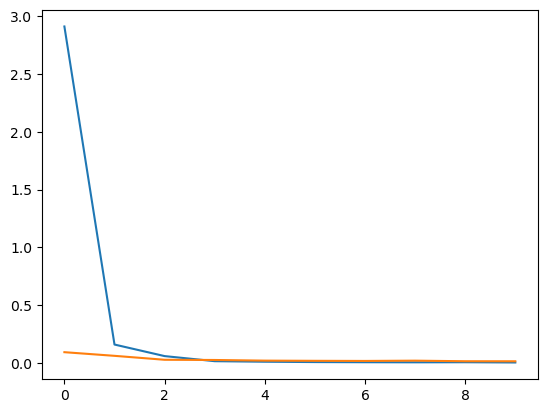

In [10]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.show()

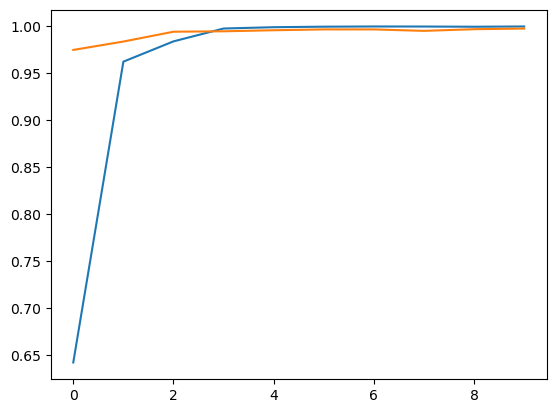

In [11]:
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.show()

**Predicting**

In [12]:
test_data_dir =  '/kaggle/input/state-farm-distracted-driver-detection/imgs/'

test_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

test_generator = test_gen.flow_from_directory(
test_data_dir,
target_size = (224,224),
batch_size = 64,
classes = ['test'],
shuffle = False)

Found 79726 images belonging to 1 classes.


In [13]:
predictions = model.predict(test_generator)
predictions.shape

1246/1246 [==============================] - 378s 303ms/step


(79726, 10)

In [14]:
file_names = sorted(os.listdir(test_data_dir+'test'))
len(file_names)

79726

In [17]:
from tensorflow.keras.utils import image_dataset_from_directory
test_data_files = image_dataset_from_directory(
    '/kaggle/input/state-farm-distracted-driver-detection/imgs/test',
     labels = None,
    label_mode=None,
)


df = pd.DataFrame(predictions)
df.columns = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
filepath = [i.split('/')[-1] for i in test_data_files.file_paths]
df1 = pd.DataFrame(filepath)
df1.columns = ['img']
df = df1.join(df)
df.to_csv('/kaggle/working/output.csv',index=False)


Found 79726 files belonging to 1 classes.


In [18]:
df.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_38770.jpg,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000e+00
1,img_3543.jpg,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000e+00
2,img_63954.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.865505e-23
3,img_41037.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000e+00
4,img_27841.jpg,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
